In [4]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [5]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/DataSecurity/SecurityMeasure.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [6]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [7]:
data.head()

,Clause,Category
0,Access to your personally identifiable informa...,[Data access limitation]
1,We also require that these contractors (i) pro...,[Generic]
2,The Hill takes every effort to protect against...,[Generic]
3,Notwithstanding the above commitment to protec...,[Generic]
4,We use information for security purposes. We m...,[Generic]


In [8]:
classes_dict.head()

,Data access limitation,Generic,Privacy/Security program,Other,Unspecified,Secure data transfer,Secure user authentication,Privacy review/audit,Secure data storage,Privacy training
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [10]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [11]:
df.columns.values[2:]

array(['Data access limitation', 'Generic', 'Privacy/Security program',
       'Other', 'Unspecified', 'Secure data transfer',
       'Secure user authentication', 'Privacy review/audit',
       'Secure data storage', 'Privacy training'], dtype=object)

# Visualizing Data

In [12]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Data access limitation,114.0
1,Generic,289.0
2,Privacy/Security program,52.0
3,Other,112.0
4,Unspecified,11.0
5,Secure data transfer,96.0
6,Secure user authentication,32.0
7,Privacy review/audit,32.0
8,Secure data storage,42.0
9,Privacy training,7.0


Text(0.5, 0, 'category')

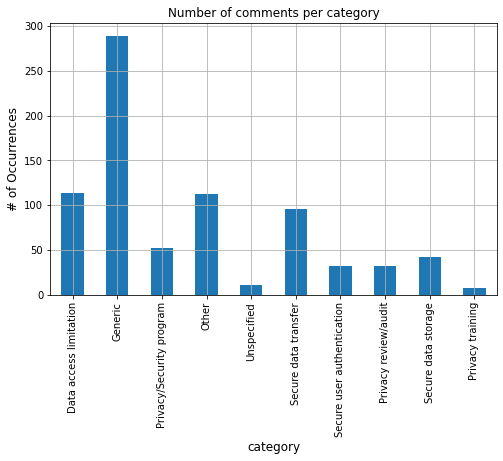

In [13]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [14]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [15]:
x_test = test.Clause
x_train = train.Clause

In [16]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [17]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<776x1866 sparse matrix of type '<class 'numpy.float64'>'
	with 19999 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [18]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Data access limitation
Test accuracy is 0.864516129032258
... Processing Generic
Test accuracy is 0.8387096774193549
... Processing Privacy/Security program
Test accuracy is 0.9612903225806452
... Processing Other
Test accuracy is 0.8580645161290322
... Processing Unspecified
Test accuracy is 0.9806451612903225
... Processing Secure data transfer
Test accuracy is 0.9032258064516129
... Processing Secure user authentication
Test accuracy is 0.9741935483870968
... Processing Privacy review/audit
Test accuracy is 0.9741935483870968
... Processing Secure data storage
Test accuracy is 0.9483870967741935
... Processing Privacy training
Test accuracy is 0.9806451612903225


array([[[131,   0],
        [ 21,   3]],

       [[ 88,   2],
        [ 23,  42]],

       [[149,   0],
        [  6,   0]],

       [[133,   0],
        [ 22,   0]],

       [[152,   0],
        [  3,   0]],

       [[137,   0],
        [ 15,   3]],

       [[151,   0],
        [  4,   0]],

       [[151,   0],
        [  4,   0]],

       [[147,   0],
        [  8,   0]],

       [[152,   0],
        [  3,   0]]], dtype=int64)

# Linear SVC

In [19]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Data access limitation
Test accuracy is 0.9225806451612903
... Processing Generic
Test accuracy is 0.8258064516129032
... Processing Privacy/Security program
Test accuracy is 0.9483870967741935
... Processing Other
Test accuracy is 0.832258064516129
... Processing Unspecified
Test accuracy is 0.9806451612903225
... Processing Secure data transfer
Test accuracy is 0.9741935483870968
... Processing Secure user authentication
Test accuracy is 0.9806451612903225
... Processing Privacy review/audit
Test accuracy is 0.9806451612903225
... Processing Secure data storage
Test accuracy is 0.9483870967741935
... Processing Privacy training
Test accuracy is 0.9806451612903225


array([[[129,   2],
        [ 10,  14]],

       [[ 82,   8],
        [ 19,  46]],

       [[147,   2],
        [  6,   0]],

       [[125,   8],
        [ 18,   4]],

       [[152,   0],
        [  3,   0]],

       [[135,   2],
        [  2,  16]],

       [[151,   0],
        [  3,   1]],

       [[150,   1],
        [  2,   2]],

       [[145,   2],
        [  6,   2]],

       [[152,   0],
        [  3,   0]]], dtype=int64)

# Logistic Regression

In [20]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Data access limitation
Test accuracy is 0.9032258064516129
... Processing Generic
Test accuracy is 0.832258064516129
... Processing Privacy/Security program
Test accuracy is 0.9612903225806452
... Processing Other
Test accuracy is 0.8580645161290322
... Processing Unspecified
Test accuracy is 0.9806451612903225
... Processing Secure data transfer
Test accuracy is 0.9483870967741935
... Processing Secure user authentication
Test accuracy is 0.9741935483870968
... Processing Privacy review/audit
Test accuracy is 0.9741935483870968
... Processing Secure data storage
Test accuracy is 0.9483870967741935
... Processing Privacy training
Test accuracy is 0.9806451612903225


array([[[131,   0],
        [ 15,   9]],

       [[ 86,   4],
        [ 22,  43]],

       [[149,   0],
        [  6,   0]],

       [[133,   0],
        [ 22,   0]],

       [[152,   0],
        [  3,   0]],

       [[137,   0],
        [  8,  10]],

       [[151,   0],
        [  4,   0]],

       [[151,   0],
        [  4,   0]],

       [[147,   0],
        [  8,   0]],

       [[152,   0],
        [  3,   0]]], dtype=int64)

In [21]:
import pickle
#saving model
list_of_classifiers = classifier_list_lr
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [17]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=